In [6]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import data_gen2
import tropical

from ipywidgets import Output
from IPython.display import display, Markdown, Latex, Math, clear_output

%matplotlib notebook
#plt.ion()

%load_ext tikzmagic

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # I don't have a GPU to test this

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


In [7]:
# Set up the ReLULayer Pytorch module
# Apply affine transformation then rectified linear unit
class ReLULayer(nn.Module):
    # Set up a ReLU layer for ease of use
    def __init__(self, input_dim, output_dim):
        super(ReLULayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim) # Just one affine transformation

    def forward(self, x):
        return F.relu(self.linear(x)) # Apply the affine transformation and then the ReLU

In [8]:
# Set up the NeuralNetwork class
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_structure, learning_rate=0.001):
        super(NeuralNetwork, self).__init__()
        self.hidden_structure = hidden_structure

        layers = []
        layers.append(ReLULayer(input_dim, hidden_structure[0])) # Setup initial hidden layer

        for i in range(1, len(hidden_structure)):
            layers.append(ReLULayer(hidden_structure[i-1], hidden_structure[i])) # Setup hidden layers

        layers.append(nn.Linear(hidden_structure[-1], output_dim)) # Setup output layer (linear)

        self.layers = nn.ModuleList(layers)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        self.num_params = sum([np.prod(p.size()) for p in model_parameters])

    def forward(self, x):
        out = x

        for layer in self.layers:
            out = layer(out) # Apply hidden layers

        return out

    def train(self, X_train, y_train, loss_function):
        pred = self(X_train) # Predict from our inputs
        loss = loss_function(pred, y_train) # Calculate the loss
        # Backpropgate
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss

In [9]:
# Set up the data generators
def circles(n, r1=0.5):
    x = np.zeros((n, 2))
    y = np.zeros((n, 2))
    i = 0
    
    r1sqr = r1**2
    r2sqr = 2*r1sqr
    r3sqr = 3*r1sqr

    while i < n//2:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if np.sum(np.square(sample)) < r1sqr:
            x[i, :] = sample
            y[i, :] = np.array([0, 1])
            i += 1

    while i < n:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if r2sqr < np.sum(np.square(sample)) < r3sqr:
            x[i, :] = sample
            y[i, :] = np.array([1, 0])
            i += 1

    return x, y

def circlesAlt(n, r1=0.5):
    x = np.zeros((n, 2))
    y = np.zeros((n, 1))
    i = 0
    
    r1sqr = r1**2
    r2sqr = 2*r1sqr
    r3sqr = 3*r1sqr

    while i < n//2:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if np.sum(np.square(sample)) < r1sqr:
            x[i, :] = sample
            y[i, :] = 1
            i += 1

    while i < n:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if r2sqr < np.sum(np.square(sample)) < r3sqr:
            x[i, :] = sample
            y[i, :] = -1
            i += 1

    return x, y

In [16]:
# Run the network and display steps

# Data info
num_inputs = 2
num_outputs = 1
num_samples = 50
hidden_structure = [5]
data_func = lambda n: circlesAlt(n)

# Hyper-parameters 
num_epochs = 10000
learning_rate = 0.001

# Setup for the network
model = NeuralNetwork(num_inputs, num_outputs, hidden_structure, learning_rate=learning_rate).to(device)

# Count the number of trainable parameters and display it
#print('Number of parameters:', model.num_params)

# Set up optimization technique
#loss_function = nn.BCEWithLogitsLoss() # Binary cross entropy
#loss_function = nn.CrossEntropyLoss() # Multi-class
#loss_function = nn.L1Loss() # L1 norm
loss_function = nn.MSELoss() # L2 norm divided by num samples 



thing = 101
x = np.linspace(-1, 1, thing)
y = np.linspace(-1, 1, thing)

X, Y = np.meshgrid(x, y)

x = np.reshape(X, thing**2)
y = np.reshape(Y, thing**2)

X_train2 = np.vstack((x, y)).T

indices = X_train2[:, 0]**2 + X_train2[:, 1]**2 < r1sqr
X_trainCirc = X_train2[indices, :]
y_trainCirc = np.ones((X_trainCirc.shape[0], 1))

indices = np.logical_and(r2sqr < X_train2[:, 0]**2 + X_train2[:, 1]**2, X_train2[:, 0]**2 + X_train2[:, 1]**2 < r3sqr)
X_trainCirc2 = X_train2[indices, :]
y_trainCirc2 = -np.ones((X_trainCirc2.shape[0], 1))

X_trainTrueCirc = np.vstack((X_trainCirc, X_trainCirc2))
y_trainTrueCirc = np.vstack((y_trainCirc, y_trainCirc2))

X_test = torch.from_numpy(np.vstack((x, y)).T).float()

out = Output(layout={'border': '1px solid black'})

tmp = display(Math(''))



colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00',\
          '#ff00ff', '#00ffff', '#000000']

colors2 = ['#770000', '#007700', '#000077', '#777700',\
           '#770077', '#007777', '#000000']

big_num_fterms = []
big_num_fterms_used = []
big_num_gterms = []
big_num_gterms_used = []
big_accuracy = []
big_epochs = []

for hidden_structure in [[i] for i in range(1, 11)]:

    num_fterms = [[] for i in range(7)]
    num_fterms_used = [[] for i in range(7)]
    num_gterms = [[] for i in range(7)]
    num_gterms_used = [[] for i in range(7)]
    accuracy = [[] for i in range(7)]
    epochs = [[] for i in range(7)]
    
    # Setup for plotting progress
    fig = plt.figure(figsize=(10, 20))
    axTrain = fig.add_subplot(411)
    axF = fig.add_subplot(412)
    axG = fig.add_subplot(413)
    axPlane = fig.add_subplot(427)

    for i in range(7):
        model = NeuralNetwork(num_inputs, num_outputs, hidden_structure, learning_rate=learning_rate).to(device)
        for epoch in range(num_epochs):
            # Get the training data in a useful data structure
            X_train, y_train = data_func(num_samples)
            X_train = torch.from_numpy(X_train).float().to(device)
            y_train = torch.from_numpy(y_train).float().to(device)

            loss = model.train(X_train, y_train, loss_function)

            if (epoch+1) %100 == 0  or epoch == 0:
                # Display the running accuracy
                #print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, loss.item()))



                # Plot the classification map
                axTrain.clear()
                axF.clear()
                axG.clear()
                axPlane.clear()

                pred2 = model(X_test).detach().numpy()

                data_gen2.plotClassifierDataAlt(X_test, pred2, plot=(fig, axPlane), alpha=0.5)
                X_train2, y_train2 = data_func(1000)
                data_gen2.plotClassifierDataAlt(X_train2, y_train2, plot=(fig, axPlane))

                pred = model(torch.from_numpy(X_trainTrueCirc).float()).detach().numpy()
                epochs[i].append(epoch)
                accuracy[i].append(np.sum(np.equal(pred > 0, y_trainTrueCirc > 0))/(len(y_trainTrueCirc)))

                for j in range(7):
                    axTrain.plot(epochs[j], accuracy[j], c=colors[j])
                    
                axTrain.set_title('Accuracy for ' + str(hidden_structure[0]) + ' hidden units')
                axTrain.set_ylim([0.4, 1.1])
                

                params = []
                for param in model.parameters():
                    params.append(param.detach().numpy())

zz                A1 = params[0]
                b1 = params[1]
                A2 = params[2]
                b2 = params[3]

                Fterms, Gterms = tropical.getTropCoeffs(A1, b1, A2, b2)

                num_fterms[i].append(len(Fterms))
                for j in range(7):
                    axF.plot(epochs[j], num_fterms[j], '-^', c=colors[j], markeredgecolor=colors[j], markerfacecolor='none')

                x_stuff = X_train.detach().numpy().T
                temp = np.ones((1, x_stuff.shape[1]))
                x_temp = np.concatenate((x_stuff, temp), axis=0)
                x_results = np.matmul(np.array(list(Fterms)), x_temp)
                Fmax = set(np.argmax(x_results, axis=0))

                num_fterms_used[i].append(len(Fmax))

                for j in range(7):
                    axF.plot(epochs[j], num_fterms_used[j], '--o', c=colors[j], markeredgecolor=colors[j], markerfacecolor='none')

                axF.set_title('Number of F terms')

                num_gterms[i].append(len(Gterms))
                for j in range(7):
                    axG.plot(epochs[j], num_gterms[j], '-^', c=colors[j], markeredgecolor=colors[j], markerfacecolor='none')

                x_results = np.matmul(np.array(list(Gterms)), x_temp)
                Gmax = set(np.argmax(x_results, axis=0))

                num_gterms_used[i].append(len(Gmax))

                for j in range(7):
                    axG.plot(epochs[j], num_gterms_used[j], '--o', color=colors[j], markeredgecolor=colors[j], markerfacecolor='none')

                axG.set_title('Number of G terms')


                fig.canvas.draw()
                fig.canvas.flush_events()
                
    big_num_fterms.append(num_fterms)
    big_num_fterms_used.append(num_fterms_used)
    big_num_gterms.append(num_gterms)
    big_num_gterms_used.append(num_gterms_used)
    big_accuracy.append(accuracy)
    big_epochs.append(epochs)

<IPython.core.display.Math object>

<IPython.core.display.Javascript object>

(128, 2)
(128,)
(1, 128)
(1,)


NameError: name 'breakHerePlease' is not defined

<IPython.core.display.Javascript object>


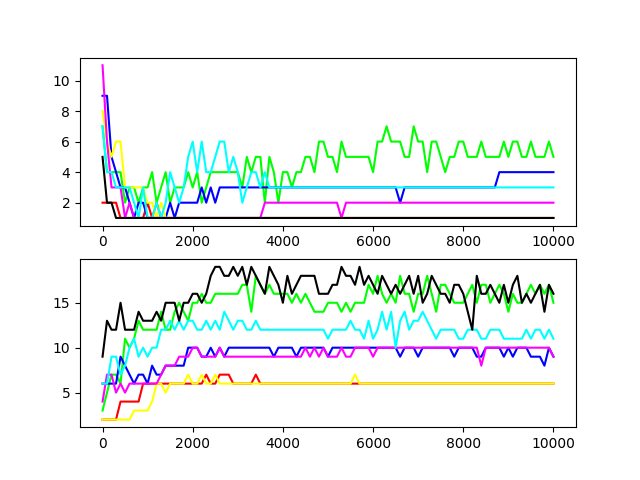

In [121]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for j in range(7):
    ax1.plot(epochs[j], num_fterms_used[j], c=colors[j], markeredgecolor=colors[j], markerfacecolor='none')
    ax2.plot(epochs[j], num_gterms_used[j], c=colors[j], markeredgecolor=colors[j], markerfacecolor='none')

In [129]:
print(np.array(big_epochs).shape)

(10, 7, 101)


In [130]:
np.savez('widthVsTropicalTerms', epochs=np.array(big_epochs), \
         gterms=big_num_gterms, fterms=big_num_fterms, \
         gterms_used=big_num_gterms_used, fterms_used=big_num_fterms_used, \
         accuracies=big_accuracy)

In [138]:
npzfile = np.load('widthVsTropicalTerms.npz')
print(npzfile.files)
print(npzfile['epochs'].shape)

['epochs', 'gterms', 'fterms', 'gterms_used', 'fterms_used', 'accuracies']
(10, 7, 101)
